##### INF8460 – Traitement automatique de la langue naturelle - Automne 2024

## TP2: Plongements de mots

## Identification de l'équipe:

### Groupe de laboratoire: G01_B1

### Equipe numéro : Eq01

### Membres:

- Zoé Paradis 2008732 (33% de contribution. nature de la contribution : Elle a réalisé tous les excercice du tp individuellement comme chaque coéquipière. Puis les codes réalisé ont été comparé avec les autres membres pour valider les réponses obtenues. Finalement, une version propre du tp a été réaliseé ensemble en combinant le code de tous les coéquipières.)
- Mahacine Ettahri 2312965 (33% de contribution. nature de la contribution : Elle a réalisé tous les excercice du tp individuellement comme chaque coéquipière. Puis les codes réalisé ont été comparé avec les autres membres pour valider les réponses obtenues. Finalement, une version propre du tp a été réaliseé ensemble en combinant le code de tous les coéquipières.)
- Xuewei Li 1879356 (33% de contribution, nature de la contribution : Elle a réalisé tous les excercice du tp individuellement comme chaque coéquipière. Puis les codes réalisé ont été comparé avec les autres membres pour valider les réponses obtenues. Finalement, une version propre du tp a été réaliseé ensemble en combinant le code de tous les coéquipières.)

* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

### Objectif du TP

L'objectif de ce TP est d'entraîner un modèle de plongements lexicaux qui intègre des notions de synonymie et d'antonymie en utilisant des réseaux de neurones. 

Contrairement aux plongements vus en cours comme GloVe ou Word2Vec, qui positionnent souvent les mots à proximité équivalente de leurs synonymes et antonymes, nous chercherons à faire distinguer à nos modèles les synonymes et antonymes, en rapprochant les mots de leurs synonymes et en les éloignant de leurs antonymes.

### Jeux de données

**Paires de synonymes et antonymes** (entraînement) : Les fichiers `train_synonyms.txt` et `train_antonymms.txt` contiennent les paires de synonymes et d'antonymes qui serviront à l'entraînement de nos modèles.
- train_synonyms: ~640k paires de synonymes
- train_antonyms: ~12k paires d'antonymes

**SimLex-999** (test) : Le fichier `simlex_english.txt` contient 1000 paires de mots et leur similarité entre 0 et 10. Des antonymes auront une similarité de 0 et des mots proches auront une similarité plus élevée. Par exemples :

- *nice* & *cruel* -> 0
- *violent* & *angry* -> 5.9
- *essential* & *necessary* -> 9.8

### Développement du TP

Le TP suivra les étapes suivantes:

- Partie 1 : Familiarisation avec GloVe, modèle de plongements de mots pré-entraîné
- Partie 2 : Évaluation de GloVe sur SimLex-999
- Partie 3 : Mise en place de la méthode d'entraînement
- Partie 4 : Entraînement de zéro (baseline)
- Partie 5 : Entraînement utilisant GloVe pré-entraîné et conclusion

Le TP est noté sur 89 points.

### Librairies autorisées

+ numpy
+ pandas
+ torch
+ matplotlib

Si vous voulez utiliser une autre librairie, veuillez demander à votre chargé de lab.

### Imports

Les imports effectués dans la cellule suivante devraient être suffisants pour faire tout ce TP.

In [68]:
# !pip install torch

In [69]:
from tqdm import tqdm
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

### 1. GloVe (10 Points)

Dans ce TP, nous allons utiliser le modèle pré-entraîné GloVe qui crée des plongements lexicaux de mots.

#### 1.1 Chargement du modèle

La cellule suivante permet charger le modèle GloVe pré-entraîné. Le chargement du modèle peut prendre quelques minutes.

In [70]:
# # Décommenter pour télécharger les GloVe embeddings à partir de https://nlp.stanford.edu/projects/glove/
# !wget http://nlp.stanford.edu/data/glove.42B.300d.zip -P /content
# !unzip /content/glove.42B.300d.zip -d /content

In [71]:
# https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip

In [72]:
pretrained_model_path = 'glove.42B.300d.txt'

data_root = 'data'

train_synonyms_path = f"{data_root}/train_synonyms.txt"
train_antonyms_path = f"{data_root}/train_antonyms.txt"

eval_simlex = f'{data_root}/simlex_english.txt'

In [73]:
def load_word_vectors(filepath, vocab=None):
    """
    Télécharge le modèle pré-entraîné de plongements de mots en pytorch
    """
    word_to_index = {}
    embeddings = []
    index = 0

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            if vocab is None or word in vocab:
                embedding = np.array(split_line[1:], dtype=np.float32)
                word_to_index[word] = index
                embeddings.append(embedding)
                index += 1
    
    embeddings = np.stack(embeddings)
    embeddings = torch.from_numpy(embeddings)
    return word_to_index, embeddings

In [74]:
word_to_index, embeddings = load_word_vectors(pretrained_model_path)

#### 1.2 Implémentez la fonction `cosine_similarity` avec pytorch et sans utiliser `torch.nn.CosineSimilarity` (2 points)

In [75]:
def cosine_similarity(a, b):
    """
    Calcule la matrice de similarité cosinus entre deux matrices

    Args : 
        a   : torch.Tensor, shape=(n, d)
        b   : torch.Tensor, shape=(m, d)

    Returns:
    torch.Tensor, shape=(n, m)
    """

    # On normalise les deux matrices a et b (norme 2)
    norm_a = torch.nn.functional.normalize(a)
    norm_b = torch.nn.functional.normalize(b)

    # On calcule le produit matriciel des deux matrices
    return torch.matmul(norm_a, norm_b.T)

In [76]:
# On calcule la similarité cosinus sur un exemple
x = torch.tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float32)
y = torch.tensor([[1, 2], [1, 2], [3, 4],[5, 6]], dtype=torch.float32)

cosine_similarity(x,y)

tensor([[1.0000, 1.0000, 0.9839, 0.9734],
        [0.9839, 0.9839, 1.0000, 0.9987],
        [0.9734, 0.9734, 0.9987, 1.0000]])

#### 1.3 Complétez la fonction `n_closest_vect` qui retourne les n mots les plus proches d'un mot donné. (5 points)

`n_closest_vect` prendra en entrée la matrice des plongements `embeddings`, le dictionnaire de correspondance entre les mots et les indices `word_to_index`, le plongement d'un mot `word` et le nombre `n` de mots attendus. La fonction devra retourner la liste des mots dont les plongements sont les plus proches du vecteur de référence et leur similarité cosinus.

C'est-à-dire les n mots avec lesquels le mot a la plus grande similarité cosinus. Utilisez la fonction `cosine_similarity` que vous venez d'implémenter.

In [77]:
def n_closest_vect(embeddings, word_to_index, word, n=5):
    """
    Trouve les n mots les plus proches du vecteur donné et leur similarité

    Args : 
        embeddings      : torch.Tensor, shape=(vocab_size, embedding_dim)
        Matrice de plongement de tous les mots

        word_to_index   : dict
        Dictionnaire qui relie un mot à son index dans le vocabulaire

        word            : torch.Tensor, shape=(embedding_dim,)
        Plongement du mot dont on cherche les n mots les plus proches

        n               : int, number of closest words to return
        Nombre de mots à retourner

    Returns:
    Liste de tuple contenant les n mots les plus similaires avec leur coefficient
    de similarité
    """
    # On construit un dictionnaire inverse de word_to_index
    # clé = index et valeur = word
    inverse_word_to_index = {v: k for k, v in word_to_index.items()}

    # On calcule la matrice de similarité cosinus entre le mot spécifié et le reste des mots en utilisant les plongements 'embeddings'
    matrix_similarity = cosine_similarity(embeddings, word.reshape(1,-1))
    # On trie le vecteur de similarités par ordre décroissant et on récupère les indices des mots
    sorted_similarities, indices = torch.sort(matrix_similarity.flatten(), descending=True)

    # A partir des indices, on récupère les mots et les valeurs de similarités correspondantes
    similar_words = []
    for i in range(n):
        index_item = indices[i].item()
        similar_words.append((inverse_word_to_index[index_item], sorted_similarities[i].item()))

    return similar_words

In [78]:
# Exemple
print(n_closest_vect(embeddings, word_to_index, embeddings[word_to_index['morning']]))

[('morning', 1.0), ('afternoon', 0.8665473461151123), ('evening', 0.7880069613456726), ('yesterday', 0.7614549398422241), ('sunday', 0.7548925876617432)]


Sortie attendue :
```
[('morning', 1.0), ('afternoon', 0.8665473461151123), ('evening', 0.7880070209503174), ('yesterday', 0.7614548206329346), ('sunday', 0.7548925876617432)]
```

#### 1.4 Quelle est la similarité cosinus entre 'fast' et 'slow' ? Entre 'fast' et 'rapid' ? Commentez les résultats et expliquez leur origine. (3 points)

In [79]:
print('similarité cosinus entre "fast" et "slow" :', cosine_similarity(embeddings[word_to_index['fast']].reshape(1,-1), embeddings[word_to_index['slow']].reshape(1,-1)).item())
print('similarité cosinus entre "fast" et "rapid" :',cosine_similarity(embeddings[word_to_index['fast']].reshape(1,-1), embeddings[word_to_index['rapid']].reshape(1,-1)).item())

similarité cosinus entre "fast" et "slow" : 0.7113726735115051
similarité cosinus entre "fast" et "rapid" : 0.6445334553718567


### 2. Évaluation (12 Points)

#### Données

Les cellules qui suivent permettent de télécharger les données et de se restreindre au vocabulaire qui nous sera utile, pour éviter de charger des plongements inutiles.

Comme décrit dans l'introduction, nous avons 3 fichiers de données:
- Des paires de synonymes pour l'entraînement (`train_synonyms.txt`) 
- Des paires d'antonymes pour l'entraînement (`train_antonymms.txt`)
- Des paires de mots avec leur similarité pour l'évaluation (`simlex_english.txt`)

In [80]:
def load_data(filepath):
    """
    Télécharge les paires de synonymes et antonymes
    """
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            pair = line.strip().split()
            assert pair[0].startswith('en_') and pair[0].startswith('en_')
            data.append((pair[0][3:], pair[1][3:]))
    return data

def data_to_tensor(data, word_to_index):
    indices = [word_to_index[word] for pair in data for word in pair if word in word_to_index]
    return torch.tensor(indices).view(-1, 2)

In [81]:
# Données d'entraînement
train_synonyms = load_data(train_synonyms_path)
train_antonyms = load_data(train_antonyms_path)

# Données d'évaluation
evaluation_simlex = pd.read_csv(eval_simlex, sep='\t') # pd dataframe with columns 'word 1', 'word 2', 'score'

# On se restreint au vocabulaire qu'on va utiliser pour éviter de charger des embeddings inutiles
vocab = set([word for pair in train_synonyms + train_antonyms for word in pair])
eval_vocab = set(evaluation_simlex['word 1']).union(set(evaluation_simlex['word 2']))
vocab.update(eval_vocab)

glove_word_to_index, glove_embeddings = load_word_vectors(pretrained_model_path, vocab)

#### 2.1 Observation du jeu de données SimLex-999. (2 points)

Affichez l'histogramme de fréquence des scores de similarité dans le jeu de données SimLex-999. Utilisez `bins=40`. Votre axe des x doit représenter le score de similarité et votre axe des y doit représenter la fréquence. Comment interpréter un score de 0?

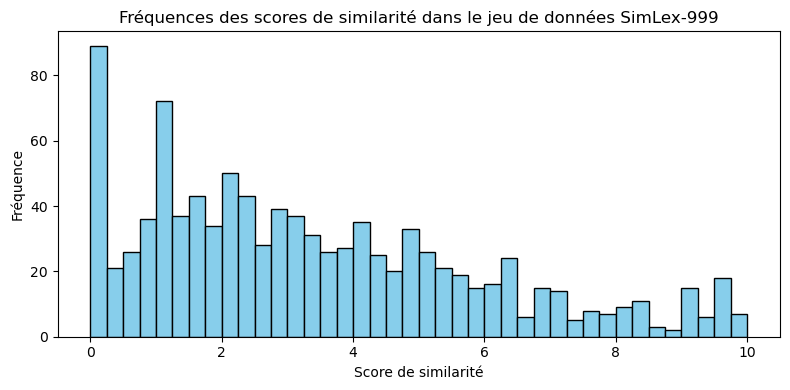

In [82]:
# On affiche un histogramme de fréquences des scores de similarité
plt.figure(figsize=(8, 4))
plt.hist(evaluation_simlex['score'], bins=40, color='skyblue', edgecolor='black')

plt.xlabel('Score de similarité')
plt.ylabel('Fréquence')
plt.title('Fréquences des scores de similarité dans le jeu de données SimLex-999')
plt.tight_layout()

In [83]:
# Exemple : Scores 0 (Analyse)
evaluation_simlex.loc[evaluation_simlex['score'] == 0]

,word 1,word 2,score
0,old,new,0.0
4,hard,easy,0.0
7,short,long,0.0
10,wide,narrow,0.0
12,easy,difficult,0.0
...,...,...,...
859,destroy,construct,0.0
861,steal,buy,0.0
863,forget,know,0.0
882,begin,quit,0.0


#### 2.2 Corrélation de Spearman


La corrélation de Spearman est une mesure de la relation monotone entre deux variables $x$ et $y$. Elle est comprise entre -1 et 1. Plutôt que de comparer les valeurs brutes des variables, elle compare leurs rangs. Elle est calculée comme suit :
$$\rho (x, y) = 1 - \frac{6 \sum_{i=1}^n (r_{x_i} - r_{y_i})^2}{n(n^2 - 1)}$$
où $r_{x_i}$ est le rang de la i-ème valeur de la variable x, $r_{y_i}$ est le rang de la i-ème valeur de la variable y, $n$ est le nombre total de paires d'observations $(x, y)$.

Les rangs sont attribués en ordonnant les valeurs de chaque variable du plus petit au plus grand. La plus petite valeur reçoit le rang 1, la suivante le rang 2, et ainsi de suite.

##### Expliquez pourquoi on utilise la corrélation de Spearman plutôt que la corrélation entre les valeurs des variables. (3 points)


#### 2.3 Implémentation de la corrélation de Spearman (2 points)

Complétez la fonction suivante pour calculer la corrélation de Spearman entre deux listes de valeurs.

In [84]:
def ranklist(x):
    """
    Calcule les rangs des éléments d'une liste.

    Args:
        x : list of float

    Returns:
    La liste des rangs des éléments de la liste en entrée. 
    """
    # On initialise deux dictionnaires avec clé = élément de x, valeur = 0
    sorted_dict, count_dict = dict.fromkeys(x,0), dict.fromkeys(x,0)

    # On parcours la liste triée (ordre croissant) des éléments de x
    # On calcule pour chaque élément son rang cumulatif et sa fréquence (le nombre d'apparition)
    # Rang cumulatif : si par exemple item = 3 apparaît aux positions 2 et 5, son rang cumulatif = 3 + 6
    for idx,item in enumerate(sorted(x)):
        sorted_dict[item] += (idx+1)
        count_dict[item] = x.count(item)

    # On calcule le rang moyen pour chaque élément
    # Ceci est utilisé surtout pour attribuer le même rang à toutes les apparitions d'un élément qui apparaît plus qu'une fois
    return np.array([sorted_dict[i] / count_dict[i] for i in x])
    
def spearman_rank_correlation(x, y):
    """
    Calcule la corrélation de Spearman entre deux listes de valeurs.

    Args:
        x   : list of float
        y   : list of float

    Returns:
    La corrélation de Spearman entre les deux listes (float). 
    """
    n = len(x)
    return 1 - np.sum((ranklist(x) - ranklist(y))**2)*6 / n / (n**2-1)

In [85]:
# Exemple : Rank
x = [40, 10, 20, 10]
y = [40, 5, 10, 5]
print(ranklist(x))
print(ranklist(y))

[4.  1.5 3.  1.5]
[4.  1.5 3.  1.5]


#### 2.4 Évaluation du modèle GloVe (2 points)


Retrouvez les plongements du modèle GloVe de tous les mots du jeu de données SimLex-999, puis calculez la similarité cosinus entre les paires.

Calculez ensuite la corrélation de Spearman entre les scores de simlex et les similarités cosinus obtenues et affichez-la.

In [86]:
similarity_paires = []

# On récupère pour chaque paire de mots les plongements GloVe et on calcule la similarité
for word1, word2 in zip(evaluation_simlex['word 1'], evaluation_simlex['word 2']):
    embedding_word1 = glove_embeddings[glove_word_to_index[word1]].reshape(1, -1)
    embedding_word2 = glove_embeddings[glove_word_to_index[word2]].reshape(1, -1)
    similarity_paires.append(cosine_similarity(embedding_word1, embedding_word2).item())

# On utilise les similarités calculées pour calculer la corrélation de Spearman avec les scores de simlex
spearman_rank_correlation(similarity_paires, list(evaluation_simlex['score']))

0.2916370157732884

Résultat attendu: 0.29

#### 2.5 Interprétation du résultat (3 points)

Qu'est ce que ce nombre représente et que peut-on en conclure sur la qualité des plongements GloVe (2 conclusions) ?

### 3. Description de la méthode contrastive (33 Points)

Nous allons maintenant implémenter une méthode contrastive de plongements de mots. Elle vise à améliorer les plongements lexicaux de mots en tenant compte des synonymes et antonymes. 

Notre modèle se basera simplement sur une matrice de plongements de mots, qui associe à chaque mot un vecteur de plongement.

L'idée est d'entraîner ce modèle à rapprocher les plongements de synonymes et d'éloigner ceux d'antonymes.

La cellule suivante définit le modèle et ses attributs.

In [87]:
class ContrastiveWordEmbeddingModel(nn.Module):
    def __init__(self, embeddings, device='cpu', margin_plus=0.6, margin_minus=0., regularization=1e-9):
        super(ContrastiveWordEmbeddingModel, self).__init__()
        
        self.device = device

        # Hyperparamètres pour les fonctions de coût
        self.margin_plus = margin_plus
        self.margin_minus = margin_minus
        self.regularization = regularization
        
        # Initialisation des plongements de mots
        self.embeddings = nn.Embedding.from_pretrained(embeddings.detach().clone(), freeze=False).to(self.device)
        self.original_embeddings = nn.Embedding.from_pretrained(embeddings.detach().clone(), freeze=True).to(self.device)

#### 3.1 Création des négatifs

Pendant l'entraînement, au lieu de traiter tout le jeu d'entraînement d'un coup, nous allons avoir des lots (batchs) de paires de synonymes $B_S$ et d'antonymes $B_A$.

Dans un lot de synonymes, on définit le négatif d'un mot comme le mot du lot le plus proche qui n'est pas dans la même paire. Intuitivement, c'est le mot que le modèle devrait confondre le plus avec le synonyme. Similairement, dans un lot d'antonymes, on définit le négatif d'un mot comme le mot du lot le plus éloigné qui n'est pas dans la même paire.

On répète ce processus pour chaque mot de chaque paire de synonymes et d'antonymes.

*Attention, un mot peut apparaître plusieurs fois dans un lot avec des synonymes ou antonymes différents, et il ne peut être le négatif d'aucun de ses synonymes, ou antonymes.*

##### 3.1.1 Exemple pour illustrer l'implémentation

Prenons un exemple avec un lot $B_S$ de synonymes de taille 3. On veut construire le lot de négatifs $T_S$

$B_S$:
- (arbre, plante)
- (voiture, véhicule)
- (arbre, buisson)

On a 5 mots uniques dans le lot: arbre, plante, voiture, véhicule, buisson. Supposons que la matrice de similarité cosinus soit la suivante :

|       | arbre | plante | voiture | véhicule | buisson |
|-------|-------|--------|--------|----------|---------|
| arbre | 1     | 0.8    | 0.1    | 0.2      | 0.9     |
| plante| 0.8   | 1      | 0.3    | 0.4      | 0.7     |
| voiture| 0.1  | 0.3    | 1      | 0.9      | 0.2     |
| véhicule| 0.2 | 0.4    | 0.9    | 1        | 0.3     |
| buisson| 0.9  | 0.7    | 0.2    | 0.3      | 1       |


On commence par calculer les voisins de chaque mot du lot $B_S$. Le voisin d'un mot $m$ est défini comme tout mot qui apparait dans au moins une paire avec $m$ dans $B_S$. Un mot est aussi considéré comme son propre voisin.

- voisins de arbre : arbre, plante, buisson
- voisins de plante : plante, arbre
- voisins de voiture : voiture, véhicule
- voisins de véhicule : véhicule, voiture
- voisins de buisson : buisson, arbre

Après avoir masqué les voisins, la matrice est :

|       | arbre | plante | voiture | véhicule | buisson |
|-------|-------|--------|--------|----------|---------|
| arbre | -inf  | -inf   | 0.1    | 0.2      | -inf    |
| plante| -inf  | -inf   | 0.3    | 0.4      | 0.7     |
| voiture| 0.1  | 0.3    | -inf   | -inf     | 0.2     |
| véhicule| 0.2 | 0.4    | -inf   | -inf     | 0.3     |
| buisson| -inf | 0.7    | 0.2    | 0.3      | -inf    |

Pour calculer les négatifs, on prend le maximum de chaque ligne (donc le mot le plus similaire qui n'est pas un voisin) :

Ici,
- le négatif d'arbre est véhicule
- le négatif de plante est buisson
- le négatif de voiture est plante
- le négatif de véhicule est plante
- le négatif de buisson est plante

En reprenant le batch $B_S$:
- (arbre, plante)
- (voiture, véhicule)
- (arbre, buisson)

$T_S$ sera composé de paires composées du négatif de chaque élément de $B_S$ :

$B_S$ -> $T_S$
- (arbre, plante) $\rightarrow$ (véhicule, buisson), car le négatif d'arbre est véhicule et le négatif de plante est buisson
- (voiture, véhicule) $\rightarrow$ (plante, plante), car le négatif de voiture est plante et le négatif de véhicule est plante
- (arbre, buisson) $\rightarrow$ (véhicule, plante), car le négatif d'arbre est véhicule et le négatif de buisson est plante

$T_S$ sera donc : 
- (véhicule, buisson)
- (plante, plante)
- (véhicule, plante)

##### 3.1.2 Implémentez la fonction `prepare_neighbors` qui renvoit la liste des voisins de chaque mot dans le lot. (4 points)

Les voisins d'un mot $m$ sont tous les mots du lot qui apparaissent dans au moins une paire avec $m$. Utilisez les bons indices (indice dans la matrice d'embeddings et indice dans le lot). Le résultat est une liste de liste de voisins, où `neighbors[i]` est la liste des voisins du mot `i` dans le lot.

In [88]:
def prepare_neighbors(index_pairs, unique_idx, index_to_idx):
    """
    Prépare les voisins pour chaque mot dans les paires de mots.
    
    Args : 
        index_pairs     : torch.Tensor de seconde dimension 2
        Tensor contenant les indices des embeddings des mots dans le vocabulaire. 
        Des indices qui sont reliés ensemble par une ligne dans ce tenseur ont 
        une relation sémantique entre eux (synonymes ou antonymes).

        unique_idx      : set
        Ensemble de tous les indices qui sont mentionnés dans la liste `index_pairs`.
        
        index_to_idx    : dict
        Dictionnaire associant un indice mentionné dans `index_pairs` à son indice dans
        la liste qui sera retournée. Par exemple, si dans ce dictionnaire, la clé 4 est
        associée à la valeur 12, cela veut dire que les voisins du mot 4 dans le vocabulaire
        seront retournés à l'indice 12 dans la liste de retour.

    Returns:
    Une liste où chaque élément est une liste des indices des voisins pour chaque mot (l'indice dans la liste correspond à l'indice unique).
    """

    # On crée une copie du tensor des indices
    index_pairs_ = index_pairs.clone()

    # On remplace chaque index par idx (indice dans la liste)
    index_pairs_.apply_(lambda x : index_to_idx[x])
    # Pour chaque paire, on crée une deuxième instance inversée
    # On concatène par la suite les versions inversées avec les versions originales
    # Exemple : [[1, 2], [3, 4]] donne [[1, 2], [3, 4], [2, 1], [4, 3]]
    index_pairs_ = torch.cat((index_pairs_, torch.flip(index_pairs_, dims=[1]))).tolist()
    # On trie les paires par ordre décroissant
    index_pairs_ = sorted(index_pairs_)
    # On crée un dictionnaire tel que clé = idx, valeur = []
    index_pairs_dict = {i: [] for i in range(len(unique_idx))}

    # Pour chaque paire, on récupère l'élément dont la clé = premier élément de la paire
    # On ajoute à sa valeur (liste) dans le dictionnaire les éléments de la paire
    # Exemple : paire [1, 2] donne {1:[1,2]}
    for i in index_pairs_:        
        index_pairs_dict[i[0]].extend(i)
    
    return list(index_pairs_dict.values())

In [89]:
# Exemple

index_pairs = torch.tensor([[0, 12], [12, 31], [53, 4]])
unique_idx = {0, 4, 12, 31, 53}
index_to_idx = {0: 0, 4: 1, 12: 2, 31: 3, 53: 4}

print(prepare_neighbors(index_pairs, unique_idx, index_to_idx))

[[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]


Réponse attendue

`[[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]`

##### 3.1.3 Implémentez la fonction `select_negatives` qui renvoit un dictionnaire qui associe à chaque élément son négatif. (4 points)

Pour chaque élément du lot, on cherche le voisin le plus proche qui n'est pas le voisin de l'autre élément de la paire.

Utilisez un masque pour cacher, dans la matrice de similarité, les voisins.

La fonction utilise un paramètre `synonym` qui indique si on travaille sur un lot de synonymes ou d'antonymes. En cas de synonymes, on cherche le voisin le plus proche qui n'est pas un voisin de l'autre élément de la paire. En cas d'antonymes, on cherche le voisin le plus éloigné qui n'est pas un voisin de l'autre élément de la paire.

In [90]:
def select_negatives(indices, similarity_matrix, neighbors, synonym=True):
    """
    Sélectionne les exemples négatifs à partir de la matrice de similarité et des voisins.

    Args : 
        indices             : torch.Tensor (vocab_size)
        Indices des mots présents dans le vocabulaires
        
        similarity_matrix   : torch.Tensor (vocab_size, vocab_size)
        Matrice de similarité entre tous les mots présents dans le vocabulaire.
        
        neighbors           : list of lists
        Liste des voisins de chaque mot. Par exemple, le premier élément de la liste
        contiendra tous les voisins du mot 0 dans le vocabulaire.

        synonym             : bool, optional (default=True)
        Indique si l'on cherche des négatifs pour les synonymes (True) ou pour les antonymes (False).

    Returns:
    Dictionnaire mappant les mots avec leurs indices de négatifs {mot_index: négatif_index}.
    """
    # On mappe la valeur True avec -inf et la fonction max, et on fait le contraire pour False
    # Objectif : le masque -inf et la fonction max seront utilisés pour la sélection des négatifs dans le cas de synonymes
    inf_dict = {True:float('-inf'), False:float('inf')}  
    minmax_dict = {True:torch.max, False:torch.min}  

    dict_select_negatives= {}
    for pair in neighbors:
        # Pour chaque mot (premier élément de la liste de voisins), on met à jour la matrice de similarité
        # en attribuant -inf/inf aux cellules correspondant au mot et ses voisins pour les ignorer
        similarity_matrix[pair[0], pair] = inf_dict[synonym]
        # On sélectionne par la suite les négatifs en appliquant min ou max selon la valeurs de synonym
        dict_select_negatives[pair[0]] = minmax_dict[synonym](similarity_matrix[pair[0]], dim=0)[1].item()

    return dict_select_negatives

In [91]:
# Exemple : synonymes

indices = torch.tensor([0, 1, 2, 3, 4])
neighbors = [[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]

similarity_matrix = torch.tensor([
    [ 1.0000, -0.4263, -0.7167, -0.9838, -0.5823],
    [-0.4263,  1.0000, -0.1600,  0.5088, -0.3708],
    [-0.7167, -0.1600,  1.0000,  0.7247,  0.5631],
    [-0.9838,  0.5088,  0.7247,  1.0000,  0.4394],
    [-0.5823, -0.3708,  0.5631,  0.4394,  1.0000]
    ])

print(select_negatives(indices, similarity_matrix, neighbors, synonym=True))

{0: 1, 1: 3, 2: 4, 3: 1, 4: 2}


Réponse attendue

`{0: 1, 1: 3, 2: 4, 3: 1, 4: 2}`

In [92]:
# Exemple : antonymes

indices = torch.tensor([0, 1, 2, 3, 4])
neighbors = [[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]

similarity_matrix = torch.tensor([
    [ 1.0000, -0.4263, -0.7167, -0.9838, -0.5823],
    [-0.4263,  1.0000, -0.1600,  0.5088, -0.3708],
    [-0.7167, -0.1600,  1.0000,  0.7247,  0.5631],
    [-0.9838,  0.5088,  0.7247,  1.0000,  0.4394],
    [-0.5823, -0.3708,  0.5631,  0.4394,  1.0000]
    ])

print(select_negatives(indices, similarity_matrix, neighbors, synonym=False))

{0: 3, 1: 0, 2: 1, 3: 0, 4: 0}


##### 3.1.4 Implémentez la fonction `run_negative_extraction` qui prépare les paires de synonymes et d'antonymes et appelle `prepare_neighbors` et `select_negatives`. (4 points)

Préparez les indices uniques des mots du batch, calculez la similarité des mots, et appelez `prepare_neighbors` et `select_negatives`.

In [93]:
def run_negative_extraction(model, index_pairs, synonym=True):
    """
    Extrait les exemples négatifs pour un ensemble de paires de mots.

    Args :
        index_pairs : torch.Tensor de seconde dimension 2
        Contient les indices des mots.

        synonym     : bool, optional (default=True)
        Indique si l'on cherche des négatifs pour les synonymes (True) ou pour les antonymes (False).

    Returns:
    Dictionnaire mappant les indices des mots avec leurs indices de négatifs {mot_index: négatif_index}.
    """
    # On construit unique_idx et index_to_idx
    unique_idx = sorted(set(index_pairs.unique().tolist()))
    index_to_idx = {v: k for k, v in enumerate(unique_idx)}
    # On appelle la fonction 'prepare_neighbors' pour obtenir les voisins
    neighbors = prepare_neighbors(index_pairs, unique_idx, index_to_idx)
    
    # On récupère les plongements à partir du modèle
    word_matrix = model.embeddings(torch.tensor(unique_idx))
    # On appelle la fonction 'select_negatives'
    return select_negatives(torch.arange(len(unique_idx)), 
                            cosine_similarity(word_matrix, word_matrix), 
                            neighbors, synonym = synonym)

In [94]:
# Exemple
model = ContrastiveWordEmbeddingModel(embeddings)
index_pairs = torch.tensor([[0, 12], [12, 31], [53, 4]])
print(run_negative_extraction(model, index_pairs, synonym=True))

{0: 4, 1: 3, 2: 4, 3: 1, 4: 2}


#### 3.2 Fonctions de coût

Pour chaque paire de synonymes $(x^l, x^r)$ *pour x left et x right* dans le lot $B_S$, nous trouvons un négatif $(t^l, t^r)$ ce qui constitue le lot $T_S$:
- $ t^l $ est le mot dans le lot le plus proche de $ x^l $ mais qui n'est pas $ x^r $.
- $ t^r $ est le mot dans le lot le plus proche de $ x^r $ mais qui n'est pas $ x^l $.

De même, pour chaque paire d'antonymes $(x^l, x^r)$ dans le lot $B_A$, nous trouvons un négatif $(t^l, t^r)$ ce qui constitue le lot $T_A$:
- $ t^l $ est le mot dans le lot le plus éloigné de $ x^l $ mais qui n'est pas $ x^r $.
- $ t^r $ est le mot dans le lot le plus éloigné de $ x^r $ mais qui n'est pas $ x^l $.


Comparer un mot à son synonyme (ou antonyme) et à son négatif permet d'entraîner le modèle sur des exemples difficiles qui forcent le modèle à apprendre des représentations plus robustes.

Il y aura trois fonctions de coût :
1. **Attraction** : Attire les synonymes plus proches les uns des autres.
2. **Répulsion** : Repousse les antonymes plus loin les uns des autres.
3. **Régularisation** : Évite que les plongements ne s'éloignent trop de ceux du modèle pré-entraîné.

Les fonctions de coût sont définies comme suit, en sommant sur `i`, les paires de synonymes et d'antonymes dans les lots $B_S$ et $B_A$ :

1. **Attraction** :
$$ S(B_S, T_S) = \sum_{i=1}^{|B_S|} \left[ \max \left(0, \delta_{syn} + x_i^l t_i^l - x_i^l x_i^r \right) + \max \left( 0, \delta_{syn} + x_i^r t_i^r - x_i^l x_i^r \right) \right] $$

1. **Répulsion** :
$$ A(B_A, T_A) = \sum_{i=1}^{|B_A|} \left[ \max \left(0, \delta_{ant} + x_i^l x_i^r - x_i^l t_i^l \right) + \max \left( 0, \delta_{ant} + x_i^r x_i^l - x_i^r t_i^r \right) \right] $$

1. **Régularisation** :
$$ R(B_S, B_A) = \sum_{x_i \in V(B_S \cup B_A)} \lambda_{reg} \| \hat{x}_i - x_i \|^2 $$

La fonction de coût totale est la somme de ces trois termes :
$$ C(B_S, T_S, B_A, T_A) = S(B_S, T_S) + A(B_A, T_A) + R(B_S, B_A) $$

$\delta_{syn}$, $\delta_{ant}$ et $\lambda_{reg}$ sont des hyperparamètres.

Avec l'exemple précédent, prenons
> + $x_i^l$ : voiture
> + $x_i^r$: véhicule
> + $t_i^l$: plante
> 
> On veut que voiture et véhicule aient un plus grand produit scalaire que voiture et plante, donc que $\delta_{syn} + x_i^l t_i^l - x_i^l x_i^r <0$, et donc que $S$ soit minimisé. De même pour la deuxième partie de l'équation, symmétrique, avec le 2nd élément du couple.

##### 3.2.1 Implémentez la fonction `synonym_cost` qui calcule la fonction de coût d'attraction (sur les paires de synonymes). (5 points)

$$ S(B_S, T_S) = \sum_{i=1}^{|B_S|} \left[ \max \left(0, \delta_{syn} + x_i^l t_i^l - x_i^l x_i^r \right) + \max \left( 0, \delta_{syn} + x_i^r t_i^r - x_i^l x_i^r \right) \right] $$

Le membre de gauche pénalise si le mot de gauche est plus éloigné de son négatif que de son synonyme. De même, le membre de droite pénalise si le mot de gauche est plus éloigné de son négatif que de son synonyme.


In [95]:
def synonym_cost(model, synonym_pairs, synonym_negatives):
    """
    Calcule le coût d'attraction pour les paires de synonymes.

    synonym_pairs: liste de tuples d'indices de paires de synonymes
    synonym_negatives: dictionnaire de mots avec leurs négatifs {mot_index: négatif_index}

    Returns:
    torch.Tensor, coût total pour les paires de synonymes
    """

    # On construit unique_idx et index_to_idx
    unique_idx = sorted(synonym_pairs.unique().tolist())
    index_to_idx = {v: k for k, v in enumerate(unique_idx)}
    # On récupère à partir du modèle, la matrice des plongements pour les indices des paires en entrée
    word_matrix = model.embeddings(torch.tensor(unique_idx))
    # On crée un dictionnaire tel que clé = idx du mot, valeur = plongement
    word_matrix_dict = {i:j for i,j in enumerate(word_matrix)}

    # On récupère le paramètre delta à partir du modèle
    delta = model.margin_plus
    # On définit la fonction word_matrix_matmul qui calcule le produit de deux plongements correspondants aux indices id1 et id2
    word_matrix_matmul = lambda id1, id2 : torch.matmul(word_matrix_dict[id1], word_matrix_dict[id2])
  
    synonyme_cost = 0
    for id_, (left_index, right_index) in enumerate(synonym_pairs.tolist()):
        # Pour caque indice de la paire, on récupère son indice de liste (idx)
        left_idx = index_to_idx[left_index]
        right_idx = index_to_idx[right_index]
        # On récupère pour chaque élément de la paire son négatif
        left_nega_idx = synonym_negatives[left_idx]
        right_nega_idx = synonym_negatives[right_idx]

        # On calcule la formule du coût pour la paire courrante
        left_cost = torch.relu(delta + word_matrix_matmul(left_idx, left_nega_idx) - word_matrix_matmul(left_idx, right_idx))
        right_cost = torch.relu(delta + word_matrix_matmul(right_idx, right_nega_idx) - word_matrix_matmul(left_idx, right_idx))

        # On ajoute les valeurs calculées à la valeur de coût globale
        synonyme_cost += (left_cost + right_cost)
        
    return synonyme_cost

In [96]:
# Exemple
synonym_pairs = torch.tensor([[0, 12], [12, 31], [53, 4]])
synonym_negatives = run_negative_extraction(model, synonym_pairs, synonym=True)
print(synonym_negatives)
print(synonym_cost(model, synonym_pairs, synonym_negatives))

{0: 4, 1: 3, 2: 4, 3: 1, 4: 2}
tensor(32.0728, grad_fn=<AddBackward0>)


##### 3.2.2 Implémentez la fonction `antonym_cost` qui calcule la fonction de coût de répulsion (sur les paires d'antonymes). (5 points)

$$ A(B_A, T_A) = \sum_{i=1}^{|B_A|} \left[ \max \left(0, \delta_{ant} + x_i^l x_i^r - x_i^l t_i^l \right) + \max \left( 0, \delta_{ant} + x_i^r x_i^l - x_i^r t_i^r \right) \right] $$

Le membre de gauche pénalise si le mot de gauche est plus éloigné de son antonyme que de son négatif. De même, le membre de droite pénalise si le mot de gauche est plus éloigné de son antonyme que de son négatif.

In [97]:
def antonym_cost(model, antonym_pairs, antonym_negatives):
    """
    Calcule le coût de répulsion pour les paires d'antonymes.

    antonym_pairs: liste de tuples d'indices de paires d'antonymes
    antonym_negatives: dictionnaire de mots avec leurs négatifs {mot_index: négatif_index}

    Returns:
    torch.Tensor, coût total pour les paires d'antonymes
    """
    unique_idx = sorted(antonym_pairs.unique().tolist())
    index_to_idx = {v: k for k, v in enumerate(unique_idx)}
    word_matrix = model.embeddings(torch.tensor(unique_idx))
    word_matrix_dict = {i:j for i,j in enumerate(word_matrix)}
    
    delta = model.margin_minus
    
    word_matrix_matmul = lambda id1, id2 : torch.matmul(word_matrix_dict[id1], word_matrix_dict[id2])
    
    antonym_cost = 0
    for id_, (left_index, right_index) in enumerate(antonym_pairs.tolist()):
        left_idx = index_to_idx[left_index]
        right_idx = index_to_idx[right_index]
        left_nega_idx = antonym_negatives[left_idx]
        right_nega_idx = antonym_negatives[right_idx]
        
        left_cost = torch.relu(delta + word_matrix_matmul(left_idx, right_idx) - word_matrix_matmul(left_idx, left_nega_idx))
        right_cost = torch.relu(delta + word_matrix_matmul(right_idx, left_idx) - word_matrix_matmul(right_idx, right_nega_idx))
        
        antonym_cost += (left_cost + right_cost)
        
    return antonym_cost

In [98]:
# Exemple
antonym_pairs = torch.tensor([[0, 12], [12, 31], [53, 4]])
antonym_negatives = run_negative_extraction(model, antonym_pairs, synonym=False)
print(antonym_negatives)
print(antonym_cost(model, antonym_pairs, antonym_negatives))

{0: 1, 1: 0, 2: 1, 3: 0, 4: 3}
tensor(15.0521, grad_fn=<AddBackward0>)


##### 3.2.3 Implémentez la fonction `regularization_cost` qui calcule la fonction de coût de régularisation. (4 points)

$$ R(B_S, B_A) = \sum_{x_i \in V(B_S \cup B_A)} \lambda_{reg} \| \hat{x}_i - x_i \|^2 $$

In [99]:
def regularization_cost(model, synonym_pairs, antonym_pairs):
    """
    Calcule le coût de régularisation pour les paires de synonymes et antonymes.

    synonym_pairs: liste de tuples d'indices de paires de synonymes
    antonym_pairs: liste de tuples d'indices de paires d'antonymes

    Returns:
    torch.Tensor, coût total de régularisation
    """
    sum_=0

    # On combine les paires de synonymes et d'antonymes dans un seul tensor
    all_pairs = torch.cat((synonym_pairs,antonym_pairs))

    # On construit unique_idx et index_to_idx
    unique_idx = sorted(all_pairs.unique().tolist())
    index_to_idx = {v: k for k, v in enumerate(unique_idx)}

    # A partir du modèle, on récupère les plongements initiaux et on mappe chaque indice de mot à son plongement
    word_matrix_original = model.original_embeddings(torch.tensor(unique_idx))
    word_matrix_original_dict = {i:j for i,j in enumerate(word_matrix_original)}

    # A partir du modèle, on récupère les plongements appris et on mappe chaque indice de mot à son plongement
    word_matrix = model.embeddings(torch.tensor(unique_idx))
    word_matrix_dict = {i:j for i,j in enumerate(word_matrix)}

    # On crée une copie des paires et on remplace chaque indice 'réel' par son indice de liste
    all_pairs_ = all_pairs.clone()
    all_pairs_.apply_(lambda x : index_to_idx[x])

    # On crée une liste d'éléments uniques au lieu de paires
    flattened_pairs = torch.unique(torch.flatten(all_pairs_))

    # Pour chaque mot, on calcule la norme entre le plongement original et celui prédit
    for _, idx in enumerate(flattened_pairs.tolist()):        
        original = word_matrix_original_dict[idx]
        predict = word_matrix_dict[idx]
        sum_ += (torch.norm(original - predict, p=2))**2
    
    return model.regularization * sum_

In [100]:
synonym_pairs = torch.tensor([(0, 12), (12, 31), (53, 4)])
antonym_pairs = torch.tensor([(0, 16), (16, 20), (34, 5)])
regularization_cost(model, synonym_pairs, antonym_pairs)

tensor(0., grad_fn=<MulBackward0>)

#### 3.3 Mise en place
##### 3.3.1 Implémentez la fonction `forward` qui utilise les fonctions définies plus tôt pour calculer le coût total. (4 points)

La fonction prend en entrée un lot de synonymes et un lot d'antonymes, c'est-à-dire des paires de synonymes et des paires d'antonymes.

Vous devez trouver les négatifs de tous les mots des lots au moyen de votre fonction  run_negative_extraction puis calculer la fonction de coût totale.

In [101]:
def forward(model, synonym_pairs, antonym_pairs):
    """
    Fonction forward pour calculer le coût total.

    Args : 
        synonym_pairs   : 
        Liste de tuples d'indices de paires de synonymes

        antonym_pairs   : 
        Liste de tuples d'indices de paires d'antonymes

    Returns:
    Tenseur contenant le coût total (attraction, répulsion et régularisation)
    """
    # On récupère les négatifs
    antonym_negatives = run_negative_extraction(model, antonym_pairs, synonym=False)
    synonym_negatives = run_negative_extraction(model, synonym_pairs, synonym=True)

    # On calcule la fonction de coût total    
    total_cost = synonym_cost(model, synonym_pairs, synonym_negatives) + antonym_cost(model, antonym_pairs, antonym_negatives) + regularization_cost(model, synonym_pairs, antonym_pairs)
    
    return total_cost

In [102]:
# Exemple
synonym_pairs = torch.tensor([(0, 12), (12, 31), (53, 4)])
antonym_pairs = torch.tensor([(0, 16), (16, 20), (34, 5)])
forward(model, synonym_pairs, antonym_pairs)

tensor(44.3266, grad_fn=<AddBackward0>)

#### 3.3.2 Évaluation (3 points)

Utilisez la fonction `spearman_rank_correlation` pour compléter la fonction d'évaluation `evaluate` qui exécute le modèle sur le jeu d'évaluation et calcule la corrélation de Spearman entre les scores prédits et réels.

Utilisez `torch.no_grad()` pour éviter de stocker les gradients.

In [103]:
def evaluate(model, eval_data, word_to_index):
    """
    Calclue les prédictions du modèle sur le jeu d'évaluation puis la corrélation de Spearman entre les scores prédits et réels.

    model: modèle de plongements de mots
    eval_data: pd.DataFrame
    word_to_index: dict

    Returns:
    float, la corrélation de Spearman entre les scores prédits par le modèle et réels.
    """
    model.eval()
    device = model.device
    word_pairs = list(zip(eval_data['word 1'], eval_data['word 2']))
    eval_indices = [(word_to_index[w1], word_to_index[w2]) for w1, w2 in word_pairs if w1 in word_to_index and w2 in word_to_index]
    
    # On définit la fonction wordTensor qui retourne, à partir du modèle, le plongement de l'indice en paramètre
    wordTensor = lambda idx : model.embeddings(torch.tensor([idx]))
    
    # On calcule la similarité cosinus entre les paires de mots d'évaluation
    with torch.no_grad():
        scores_prédits = [cosine_similarity(wordTensor(a),wordTensor(b)).item() for a,b in eval_indices]
    
    # On calcule la corrélation de Spearman entre la similarité cosinus et les scores réels
    return spearman_rank_correlation(scores_prédits, list(eval_data['score']))

In [104]:
# Exemple
device = 'cuda' if torch.cuda.is_available() else 'cpu'
glove = ContrastiveWordEmbeddingModel(glove_embeddings, device = device)
evaluate(glove, evaluation_simlex, glove_word_to_index)

0.2916370157732884

### 4. Entraînement de zéro (16 Points)

Nous allons maintenant entraîner le modèle de zéro, sans utiliser les plongements GloVe pré-entraînés. Ensuite, dans la partie 5, nous entraînerons le modèle en l'initialisant avec les plongements GloVe pré-entraînés.

In [105]:
# Hyperparamètres, optimiseur et DataLoader

BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 5e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.cuda.empty_cache()
gc.collect()

train_syn_tensor = data_to_tensor(train_synonyms, glove_word_to_index)
train_ant_tensor = data_to_tensor(train_antonyms, glove_word_to_index)

syn_data_loader = DataLoader(train_syn_tensor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
ant_data_loader = DataLoader(train_ant_tensor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

#### 4.1 Complétez la cellule suivante pour créer le modèle de zéro `model_zero`, à partir d'une matrice de plongements aléatoire. (1 point)

In [106]:
model_zero = None
random_seed = 0
random_generator = torch.Generator(device=device).manual_seed(random_seed)

embeddings_size = glove_embeddings.size()
random_init_embeddings = torch.randn(embeddings_size, generator=random_generator, device = device).to(device)

# On initialise le modèle de zéro avec les plongements aléatoires
model_zero = ContrastiveWordEmbeddingModel(embeddings = random_init_embeddings, device = device)
optimizer = optim.Adam(model_zero.parameters(), lr=LEARNING_RATE)

#### 4.2 Entraînez le modèle sur le jeu des paires de synonymes et d'antonymes. (6 points)

N'oubliez pas que l'entraînement se fait sur les synonymes et antonymes et que l'évaluation se fait sur SimLex-999.

À défaut d'avoir un jeu de validation, on observe les résultats sur le corpus de test : SimLex-999. Ceci n’est fait qu’à titre illustratif pour voir l'évolution de l'apprentissage. Il ne faut pas faire de choix pour l’entrainement à partir des résultats sur le corpus de test.

*Note : Les jeux de synonymes et d'antonymes n'ont pas la même taille. Une époque (epoch) correspond à une itération sur le jeu de données le plus petit.*

In [107]:
spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
print(f'Before training, Spearman Correlation: {spearman_corr:.8f}')

loss_train = []
spearman_corrs = []

for epoch in range(NUM_EPOCHS): 
    t0 = time.time()
    loss_epoch = []
    # On active les gradients
    model_zero.train()
    i = 0
    for inputs_syn, inputs_ant in zip(syn_data_loader, ant_data_loader):
        # On réinitialise les gradients
        optimizer.zero_grad() 
        # On calcule le coût
        loss = forward(model_zero, inputs_syn, inputs_ant)
        loss_epoch.append(loss)
        # On calcule le gradient du coût par rapport aux entrées
        loss.backward()
        # On met à jour les paramètres
        optimizer.step()

    loss_epoch_avg = sum(loss_epoch) / len(loss_epoch)
    loss_train.append(loss_epoch_avg)
    print(f'Epoch {epoch + 1}, Loss: {loss_epoch_avg:.4f}, Computational time : {time.time()-t0:.1f} s')
    spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
    spearman_corrs.append(spearman_corr)
    print(f'Epoch {epoch + 1}, Spearman Correlation: {spearman_corr:.8f}')

Before training, Spearman Correlation: -0.02651944
Epoch 1, Loss: 10896.3525, Computational time : 29.6 s
Epoch 1, Spearman Correlation: 0.01932304
Epoch 2, Loss: 8356.6367, Computational time : 27.8 s
Epoch 2, Spearman Correlation: 0.05936119
Epoch 3, Loss: 6573.2710, Computational time : 30.0 s
Epoch 3, Spearman Correlation: 0.08493067
Epoch 4, Loss: 5761.5640, Computational time : 27.2 s
Epoch 4, Spearman Correlation: 0.09898919
Epoch 5, Loss: 5413.4932, Computational time : 27.5 s
Epoch 5, Spearman Correlation: 0.10601235
Epoch 6, Loss: 5173.6450, Computational time : 26.7 s
Epoch 6, Spearman Correlation: 0.11094855
Epoch 7, Loss: 4983.2554, Computational time : 26.5 s
Epoch 7, Spearman Correlation: 0.11141494
Epoch 8, Loss: 4832.3291, Computational time : 26.7 s
Epoch 8, Spearman Correlation: 0.12058700
Epoch 9, Loss: 4669.8062, Computational time : 27.1 s
Epoch 9, Spearman Correlation: 0.12773055
Epoch 10, Loss: 4504.8086, Computational time : 26.5 s
Epoch 10, Spearman Correlatio

#### 4.3 Courbes d'entraînement du modèle de zéro (4 points)

Affichez la perte moyenne sur le jeu d'entraînement et la corrélation de Spearman sur le jeu de validation à chaque époque.

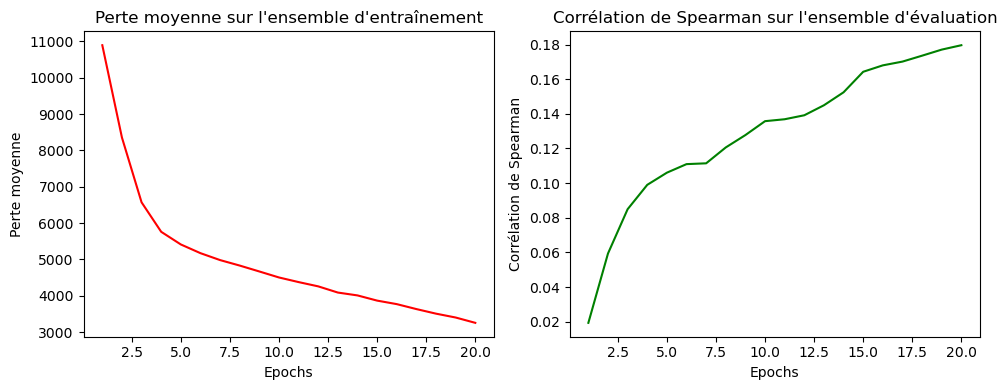

In [108]:
# On récupère les épochs, la perte d'entraînement et la corrélation de spearman pour chaque époque
epochs = [epoch + 1 for epoch in range(NUM_EPOCHS)]
loss_train_array = [elem.item() for elem in loss_train]
spearman_corrs_array = [elem.item() for elem in spearman_corrs]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs, loss_train_array, color = 'red')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Perte moyenne')
axes[0].set_title('Perte moyenne sur l\'ensemble d\'entraînement')

axes[1].plot(epochs, spearman_corrs_array, color = 'green')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Corrélation de Spearman')
axes[1].set_title('Corrélation de Spearman sur l\'ensemble d\'évaluation')

plt.tight_layout()
plt.show()

#### 4.4 Évaluation du modèle de zéro et comparaison avec GloVe (5 points)

Comparez le modèle de zéro après l'entraînement à GloVe (résultat de la partie 2.4) en termes de corrélation de Spearman sur le jeu de validation. Quelle méthode est la plus performante ? Pourquoi ?


In [109]:
# Résultat de la partie 2.4
print('Résultats avec GloVe : ', spearman_rank_correlation(similarity_paires, list(evaluation_simlex['score'])))
# Résultat après entraînement du modèle de Zéro
print('Résultats après entraînement du modèle de Zéro : ', evaluate(model_zero, evaluation_simlex, glove_word_to_index))

Résultats avec GloVe :  0.2916370157732884
Résultats après entraînement du modèle de Zéro :  0.17959663471086318


### 5. Intérêt de GloVe (18 Points)

Dans la section précédente, nous avons entraîné un modèle de zéro.

Nous allons maintenant évaluer si initialiser le modèle avec les plongements de GloVe permet d'améliorer les performances.

#### 5.1 Initialisation avec GloVe (6 points)

Entraînez le modèle `model_fine_tuned`, mais cette fois en ititialisant directement avec les plongements du modèle pré-entraîné GloVe.

On utilisera Adam comme optimiseur.

In [115]:
model_fine_tuned = None

BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 5e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.cuda.empty_cache()
gc.collect()

train_syn_tensor = data_to_tensor(train_synonyms, glove_word_to_index)
train_ant_tensor = data_to_tensor(train_antonyms, glove_word_to_index)

syn_data_loader = DataLoader(train_syn_tensor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
ant_data_loader = DataLoader(train_ant_tensor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

model_fine_tuned = ContrastiveWordEmbeddingModel(embeddings = glove_embeddings, device = device)

optimizer = optim.Adam(model_fine_tuned.parameters(), lr=LEARNING_RATE)

In [116]:
spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
print(f'Before training, Spearman Correlation: {spearman_corr:.8f}')

loss_train_tuned = []
spearman_corrs_tuned = []

for epoch in range(NUM_EPOCHS): 
    t0 = time.time()
    loss_epoch_tuned = []
    model_fine_tuned.train()
    i = 0
    for inputs_syn, inputs_ant in zip(syn_data_loader, ant_data_loader):
        optimizer.zero_grad() 
        loss = forward(model_fine_tuned, inputs_syn, inputs_ant)
        loss_epoch_tuned.append(loss)
        loss.backward()
        optimizer.step()

    loss_epoch_avg = sum(loss_epoch_tuned) / len(loss_epoch_tuned)
    loss_train_tuned.append(loss_epoch_avg)
    print(f'Epoch {epoch + 1}, Loss: {loss_epoch_avg:.4f}, Computational time : {time.time()-t0:.1f} s')
    spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
    spearman_corrs_tuned.append(spearman_corr)
    print(f'Epoch {epoch + 1}, Spearman Correlation: {spearman_corr:.8f}') 

Before training, Spearman Correlation: 0.29163702
Epoch 1, Loss: 2658.3413, Computational time : 27.5 s
Epoch 1, Spearman Correlation: 0.36909701
Epoch 2, Loss: 1394.5586, Computational time : 26.9 s
Epoch 2, Spearman Correlation: 0.43578635
Epoch 3, Loss: 839.2177, Computational time : 27.1 s
Epoch 3, Spearman Correlation: 0.46397192
Epoch 4, Loss: 639.4882, Computational time : 27.5 s
Epoch 4, Spearman Correlation: 0.47759471
Epoch 5, Loss: 539.1479, Computational time : 27.4 s
Epoch 5, Spearman Correlation: 0.48281466
Epoch 6, Loss: 472.6017, Computational time : 27.0 s
Epoch 6, Spearman Correlation: 0.48316049
Epoch 7, Loss: 438.9108, Computational time : 27.2 s
Epoch 7, Spearman Correlation: 0.48080038
Epoch 8, Loss: 405.5722, Computational time : 26.9 s
Epoch 8, Spearman Correlation: 0.48427171
Epoch 9, Loss: 385.7013, Computational time : 27.4 s
Epoch 9, Spearman Correlation: 0.48894701
Epoch 10, Loss: 361.7512, Computational time : 27.1 s
Epoch 10, Spearman Correlation: 0.48454

#### 5.2 Courbes d'entraînement (4 points)

Affichez la perte moyenne sur le jeu d'entraînement et la corrélation de Spearman sur le jeu de validation à chaque époque.

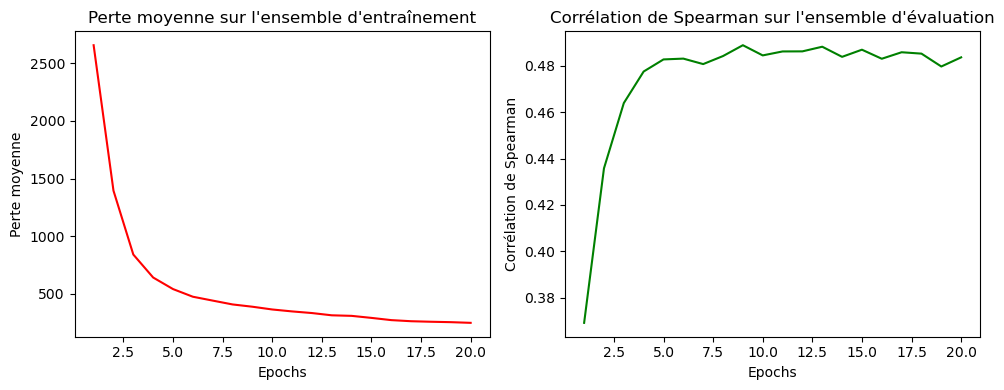

In [117]:
epochs = [epoch + 1 for epoch in range(NUM_EPOCHS)]
loss_train_tuned_array = [elem.item() for elem in loss_train_tuned]
spearman_corrs_tuned_array = [elem.item() for elem in spearman_corrs_tuned]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(epochs, loss_train_tuned_array, color = 'red')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Perte moyenne')
axes[0].set_title('Perte moyenne sur l\'ensemble d\'entraînement')

axes[1].plot(epochs, spearman_corrs_tuned_array, color = 'green')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Corrélation de Spearman')
axes[1].set_title('Corrélation de Spearman sur l\'ensemble d\'évaluation')

plt.tight_layout()
plt.show()

#### 5.3 Vérification sur un exemple (3 points)

Avec le modèle `model_fine_tuned`, calculez la similarité cosinus entre 'fast' et 'slow' et entre 'fast' et 'rapid'. Commentez les résultats en les comparant avec ceux de la partie 1.4.

In [119]:
def word_pair_to_similarity(w1, w2, embeddings):
    return cosine_similarity(embeddings[word_to_index[w1]].reshape(1,-1), embeddings[word_to_index[w2]].reshape(1,-1)).item()

ww1 = ('fast' , 'slow' )
ww2 = ('fast' , 'rapid')

emb = model_fine_tuned.embeddings.weight.data
print('**Modèle fine-tuned**')
print('Fast-Slow : ',word_pair_to_similarity(*ww1, emb), ' Fast-Rapid : ', word_pair_to_similarity(*ww2, emb))

emb = embeddings
print('**GloVe**')
print('Fast-Slow : ',word_pair_to_similarity(*ww1, emb), ' Fast-Rapid : ', word_pair_to_similarity(*ww2, emb))

**Modèle fine-tuned**
Fast-Slow :  0.14490196108818054  Fast-Rapid :  0.36047542095184326
**GloVe**
Fast-Slow :  0.7113726735115051  Fast-Rapid :  0.6445334553718567


#### 5.4 Analyse, comparaison, conclusion (5 points)

Comparez les performances des trois modèles (GloVe, zéro, fine-tuned). Quelle méthode est la plus performante ? Pourquoi ?


In [120]:
print('Résultats avec GloVe : ', spearman_rank_correlation(similarity_paires, list(evaluation_simlex['score'])))
print('Résultats après entraînement du modèle de Zéro : ', evaluate(model_zero, evaluation_simlex, glove_word_to_index))
print('Résultats après entraînement du modèle Fine-tuned : ', evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index))

Résultats avec GloVe :  0.2916370157732884
Résultats après entraînement du modèle de Zéro :  0.17959663471086318
Résultats après entraînement du modèle Fine-tuned :  0.4837103636702835


## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


## Évaluation 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code et obtention des sorties attendues
2. Réponses correctes aux questions d'analyse
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs